<a href="https://colab.research.google.com/github/OmarDrira/CS414FinalProject/blob/main/FinalProjectCS414_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we will build a machine learning model that predicts the closing price of XRP, a popular cryptocurrency. 

# Section 1: XRP closing price prediction 

First, we import the necessary packages

In [ ]:
# Importing required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

Now, we load the data from the csv file. The csv file contains the historical data of XRP. We create a dataframe that contains all the characteristics of the data : Date, Open, High, Low, Close, and Volume. We can see the format of the data below. The prices range from 2017 up until May 2023.

In [ ]:
# Loading the dataset
data = pd.read_csv("XRP-USD.csv")
print(data.head(0)) # prints the headers
data = data.loc[:,['Date','Open','High','Low','Close', 'Volume']]
print(data.head(5)) # prints first 5 rows of data
print(data.Date) # prints only the 'Date' column

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []
         Date      Open      High       Low     Close     Volume
0  2017-11-09  0.217911  0.221791  0.214866  0.217488  147916992
1  2017-11-10  0.218256  0.219068  0.205260  0.206483  141032992
2  2017-11-11  0.205948  0.214456  0.205459  0.210430  134503008
3  2017-11-12  0.210214  0.210214  0.195389  0.197339  251175008
4  2017-11-13  0.197472  0.204081  0.197456  0.203442  132567000
0       2017-11-09
1       2017-11-10
2       2017-11-11
3       2017-11-12
4       2017-11-13
           ...    
1995    2023-04-27
1996    2023-04-28
1997    2023-04-29
1998    2023-04-30
1999    2023-05-01
Name: Date, Length: 2000, dtype: object


In [ ]:
# Setting the index and converting it into a datetime format
data = data.set_index('Date')
data.index = pd.to_datetime(data.index,unit='ns')
print(data.index)  

DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25',
               '2023-04-26', '2023-04-27', '2023-04-28', '2023-04-29',
               '2023-04-30', '2023-05-01'],
              dtype='datetime64[ns]', name='Date', length=2000, freq=None)


Now we set the target variable (aim) to be the closing price

In [ ]:
# Specifying the target column for prediction
aim = 'Close'

We break the data into three different sets: training set, validation set, and test set. We define two functions that help us plotting.

In [ ]:
# Dividing the data into training, validation, and testing sets
train_data = data.iloc[0:1500]
val_data = data.iloc[1500:1750]
test_data = data.iloc[1750:]

# Functions to plot multiple lines on a graph
def line_plot2(line1, line2,  label1=None, label2=None,  title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('XRP/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

def line_plot(line1, line2, line3,  label1=None, label2=None,  label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('XRP/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

Here, we can see the training, validation and test sets on a graph.

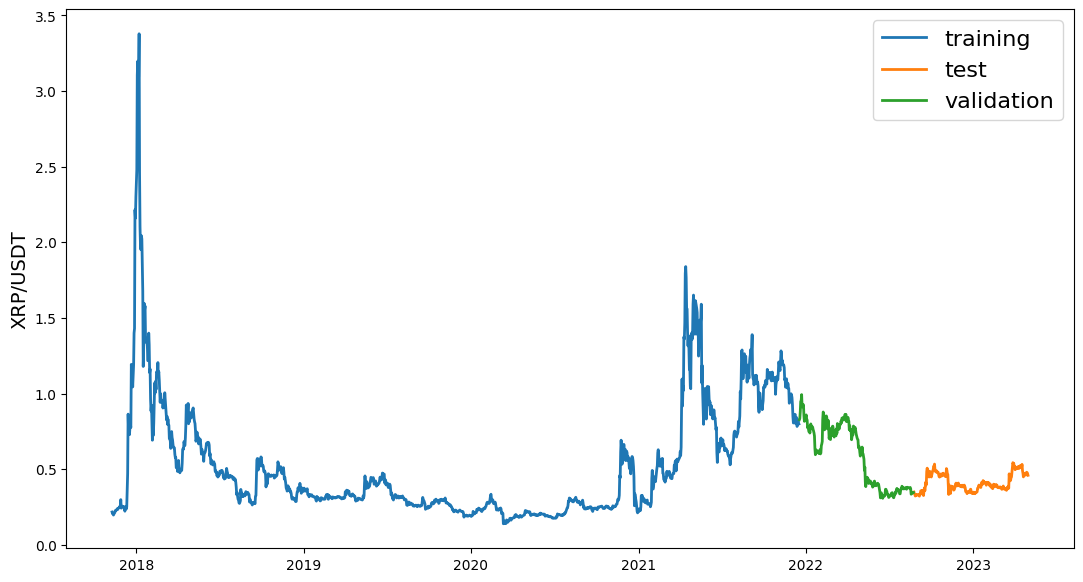

In [ ]:
# Plotting the training, testing, and validation data
line_plot(train_data[aim], test_data[aim], val_data[aim], 'training', 'test', 'validation', title='')

Here we normalise the data. The normalise_zero_base function normalizes the data to have a zero base. The normalise_min_max function normalizes the data to have a minimum value of zero and a maximum value of one.

In [ ]:
# Function to normalise the data
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

# Function to normalise the data using min-max scaling
def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

Here we define the function extract_window_data for extracting the window data from the continuous data. The window length is set to 5. The function also has a parameter for setting whether or not the data should be zero-based.

The prepare_data function is defined for preparing the data for the LSTM neural network. The function calls the extract_window_data function to extract the window data for the training, validation, and test sets. The function also normalizes the data and returns the training, validation, and test sets as well as the window data and target values for each set.

In [ ]:
# Function to extract the windowed data
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
# Function to prepare the training, validation, and testing data for LSTM
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_val = extract_window_data(val_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    y_val = val_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1
        y_val = y_val / val_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_val, X_test, y_train, y_val, y_test
import numpy as np

In [ ]:
from tensorflow.keras import layers

We define the build_lstm_model function for building the LSTM neural network model. The function takes the input data, output size, number of neurons, activation function, dropout rate, loss function, and optimizer as parameters. The function adds an LSTM layer with the specified number of neurons and a dropout layer with the specified dropout rate. The output layer is a dense layer with the specified output size and activation function. The function compiles the model using the specified loss function and optimizer.

In [ ]:
# Function to build  LSTM model
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential() # Create a sequential model
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]))) # Add an LSTM layer with specified number of neurons and input shape
    model.add(Dropout(dropout)) # Add dropout regularization to prevent overfitting
    model.add(Dense(units=output_size)) # Add a dense layer with output size
    model.add(Activation(activ_func)) # Add an activation function to the output layer
    # Compile the model with specified loss and optimizer
    model.compile(loss=loss, optimizer=optimizer)
    return model
    
# Set random seed for reproducibility
np.random.seed(245)
# Set the window length for the data
window_len = 5
# Set the size of the test set
test_size = 0.2
# Specify if the data should be zero-based
zero_base = True
# Set the number of neurons in the LSTM layer
lstm_neurons = 50
# Set the number of epochs for training
epochs = 20
# Set the batch size for training
batch_size = 32
# Set the loss function to use
loss = 'mse'
# Set the dropout rate for regularization
dropout = 0.15
# Set the optimizer to use
optimizer = 'adam'
# Prepare the data for training and testing
train_data, test_data, X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)

Here, we can see the shape of our training

In [ ]:
print(X_train.shape) # Print the shape of the training input data

(1495, 5, 5)


Now we build the model and we train it

In [ ]:
# Build the LSTM model using the training input data
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
# Fit the model to the training data and validate on the validation data
modelfit = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
47/47 [==============================] - 3s 18ms/step - loss: 0.0251 - val_loss: 0.0081
Epoch 2/20
47/47 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.0052
Epoch 3/20
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0043
Epoch 4/20
47/47 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.0040
Epoch 5/20
47/47 [==============================] - 0s 10ms/step - loss: 0.0106 - val_loss: 0.0037
Epoch 6/20
47/47 [==============================] - 0s 9ms/step - loss: 0.0101 - val_loss: 0.0033
Epoch 7/20
47/47 [==============================] - 1s 13ms/step - loss: 0.0096 - val_loss: 0.0029
Epoch 8/20
47/47 [==============================] - 1s 13ms/step - loss: 0.0093 - val_loss: 0.0028
Epoch 9/20
47/47 [==============================] - 1s 16ms/step - loss: 0.0092 - val_loss: 0.0027
Epoch 10/20
47/47 [==============================] - 1s 16ms/step - loss: 0.0095 - val_loss: 0.0024
Epoch 11/20
4

Here we can see the learning curves

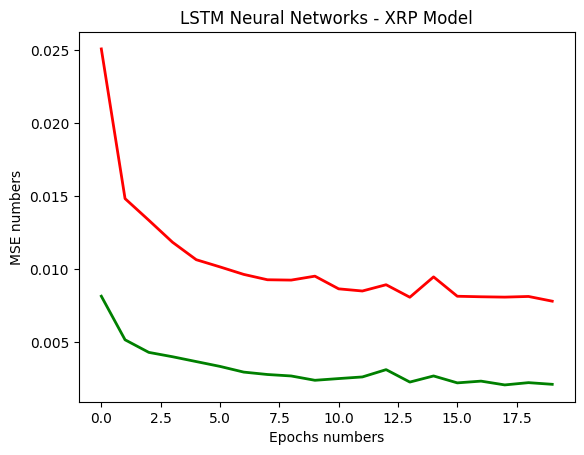

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss for each epoch
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

Here we can see the mean absolute error score

In [ ]:
# Get the targets and predictions for the test data
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
# Compute the mean absolute error between the predictions and actual test values
mean_absolute_error(preds, y_test)

8/8 [==============================] - 1s 4ms/step


0.0287302289411743

In [ ]:
from sklearn.metrics import mean_squared_error
# Compute the mean squared error between the predictions and actual test values
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.001935365487089735

Here we can see the r2 score

In [ ]:
from sklearn.metrics import r2_score
# Compute the R-squared score between the predictions and actual test values
r2_score=r2_score(y_test, preds)
r2_score*100

71.50896765514729

And here we can see the plot of our predictions compared to the actual prices

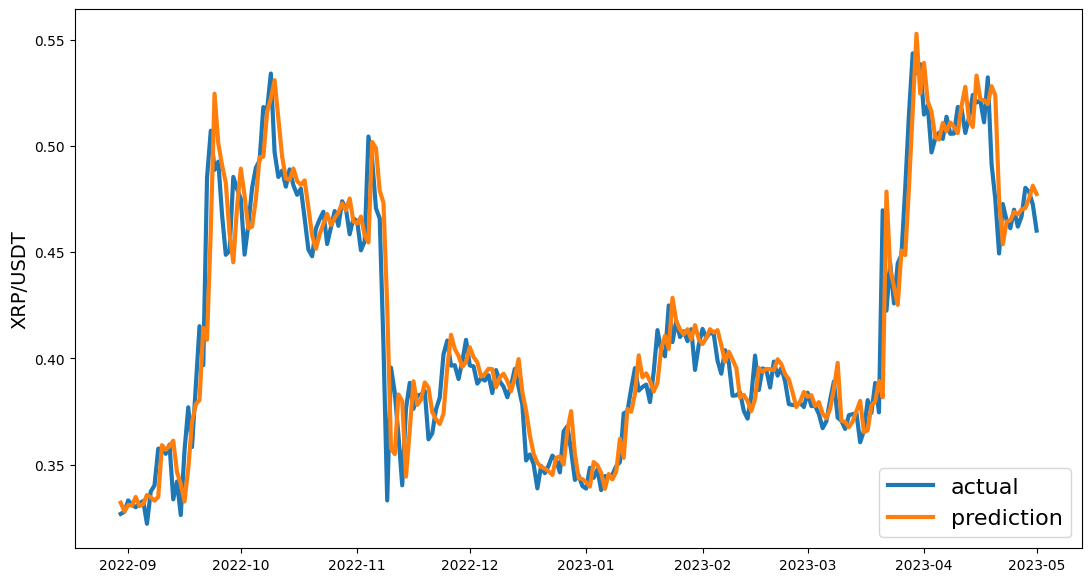

In [ ]:
# Rescale the predictions using the test data and plot the results
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot2(targets, preds, 'actual', 'prediction', lw=3)

Clearly by looking at the plot and both the MSE and r2 scores, the model is doing a great job predicting the closing price. Let's hypothetically use these results to invest 1000$ and see how much money we can make.

In [ ]:
# initialize investment parameters
cash = 1000
shares = 0

# simulate investment using preds and target
for i in range(1, len(preds)):
    if preds[i] > preds[i-1]:  # buy
        shares_to_buy = int(cash / targets[i])
        if shares_to_buy > 0:  # check if we have enough cash to buy at least one share
            shares += shares_to_buy
            cash -= shares_to_buy * targets[i]
    elif preds[i] < preds[i-1]:  # sell
        cash += shares * targets[i]
        shares = 0

# print final investment results
print(f"Final cash: ${cash:.2f}")
print(f"Final shares: {shares}")
print(f"Total value: ${cash + shares * targets[-1]:.2f}")


Final cash: $1130.54
Final shares: 0
Total value: $1130.54


As we can see, we end up with a net profit in terms of total value. This means that our model performs really well. However, this is actually not true in real life.

The model is predicting tomorrow’s closing price based on the past 5 days (window_len) one step at a time. So once it predicts tomorrow's price, it will store it, then use the actual closing price of tomorrow (along with the four previous ones) to predict the next day. This is not as impressive as it looks since the model is simply predicting a value within a close range to the previous one, one step at a time, and it cannot veer off too much since, if it does a little, it will be corrected in the next day by using the previous day's actual closing price.  

In the next two section, we will use different methods to predict the XRP price to see if we can get better results. First, we will use the same model to predict the price movement instead and see how well the model perform.
After that, we will use the model's own predictions to predict the future closing price

# Section 2 : XRP price difference prediction 

Now let's see what happens when we choose a different target variable. In this section we will try to predict the difference in the closing price from one day to another.

This data is not part of our original file so we will need to create it oursleves.

In [ ]:
data.Close
diff = [0.000001]
for i in range(1, len(data.Close)):
    diff.append(data.Close[i] - data.Close[i-1])

data['Difference'] = diff


From the closing price data we have created a list of the price change day to day by taking the current price and subtracting the previous days price. Lets take a look at the new data.

In [ ]:
print(data.head(0))
print(data.head(5))

Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Difference]
Index: []
                Open      High       Low     Close     Volume  Difference
Date                                                                     
2017-11-09  0.217911  0.221791  0.214866  0.217488  147916992    0.000001
2017-11-10  0.218256  0.219068  0.205260  0.206483  141032992   -0.011005
2017-11-11  0.205948  0.214456  0.205459  0.210430  134503008    0.003947
2017-11-12  0.210214  0.210214  0.195389  0.197339  251175008   -0.013091
2017-11-13  0.197472  0.204081  0.197456  0.203442  132567000    0.006103


Now our dataset is equiped with a new column called 'Difference' We will now set our aim to 'Difference' and create initialize the training, validation, and testing data.

In [ ]:
aim = 'Difference'
train_data = data.iloc[0:1500]
val_data = data.iloc[1500:1750]
test_data = data.iloc[1750:]


Let's take a look at our new data:

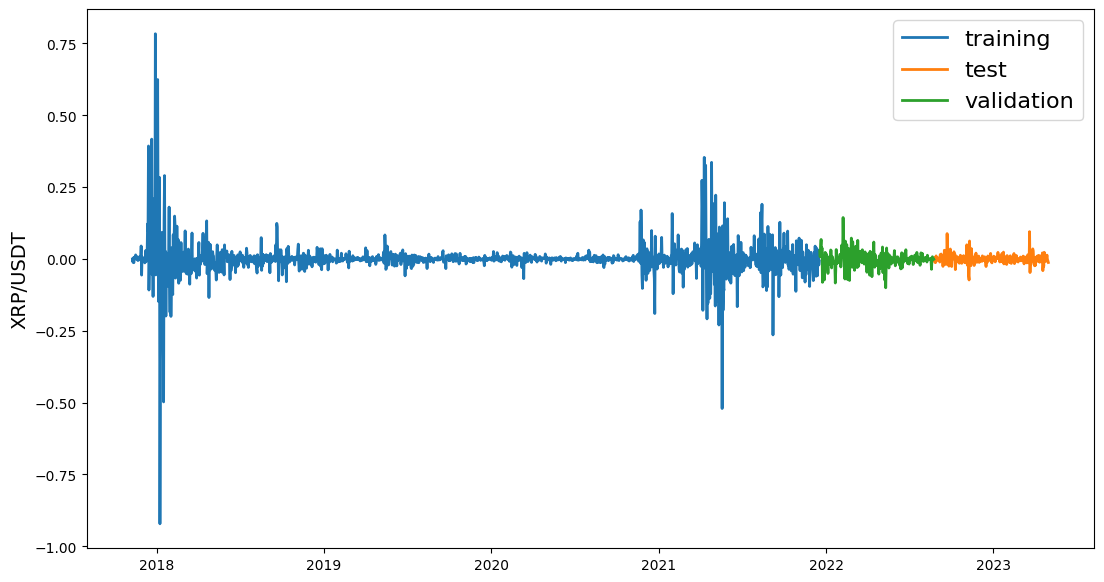

In [ ]:
line_plot(train_data[aim], test_data[aim], val_data[aim], 'training', 'test', 'validation', title='')

Our next step is to prepare our data for the LSTM model as we have done before.

In [ ]:
train_data, test_data, X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)
print(X_train.shape)

(1495, 5, 6)


We can see that the shape has changed which indicates we are now using 'Diference' as another metric. 

Now lets built and train our model.

In [ ]:

model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
47/47 [==============================] - 3s 20ms/step - loss: 29033.8086 - val_loss: 63.2673
Epoch 2/20
47/47 [==============================] - 1s 11ms/step - loss: 29026.2051 - val_loss: 63.5736
Epoch 3/20
47/47 [==============================] - 0s 10ms/step - loss: 29018.0234 - val_loss: 64.0918
Epoch 4/20
47/47 [==============================] - 0s 10ms/step - loss: 29015.8867 - val_loss: 64.3136
Epoch 5/20
47/47 [==============================] - 1s 11ms/step - loss: 29008.9238 - val_loss: 64.9589
Epoch 6/20
47/47 [==============================] - 1s 12ms/step - loss: 29007.1387 - val_loss: 65.3138
Epoch 7/20
47/47 [==============================] - 1s 11ms/step - loss: 29006.9316 - val_loss: 65.4147
Epoch 8/20
47/47 [==============================] - 0s 9ms/step - loss: 29001.9727 - val_loss: 65.7156
Epoch 9/20
47/47 [==============================] - 0s 10ms/step - loss: 29005.7793 - val_loss: 66.0041
Epoch 10/20
47/47 [==============================] - 1s 11ms/step

Now we will evalutae the performance of our model.

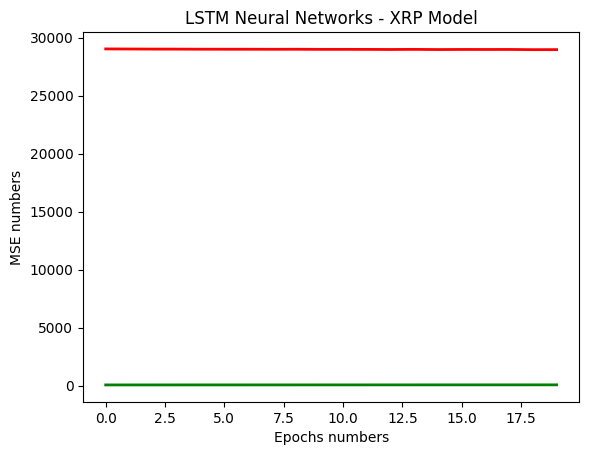

In [ ]:
import matplotlib.pyplot as plt
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [ ]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

8/8 [==============================] - 1s 3ms/step


3.9598532572487573

In [ ]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

164.84505797717458

In [ ]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

5.530561051500027

We can see that the mean squared error and absolute error are very high and our r^2 value is much worse than before. 

Let's take a look at our actual prediction to see what's going on.

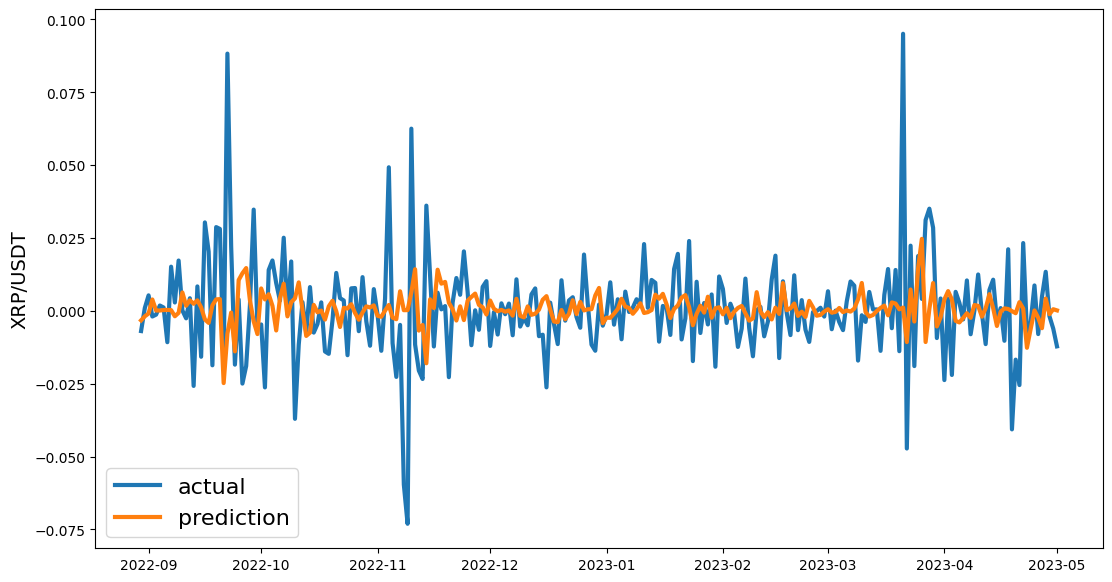

In [ ]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot2(targets, preds, 'actual', 'prediction', lw=3)

Clearly our model is unable to predict the price difference give the current input data. This shows us as we had hypothesised before, Our model in section 1 was not accuratly predicting the closing price but rather just taking the previous day and slighlty changing the price as it's prediction for the next day. This looks good over time but cannot accuratly predict far into the future for days we haven't seen yet.

For our final performance test let's take a look at how much money we would make day trading using our predictions. If the prediction for the next day is positive we'll buy and if it's negative we'll sell

In [ ]:
targets = test_data['Close'][window_len:]

In [ ]:
# initialize investment parameters
cash = 1000
shares = 0

# simulate investment using preds and target
for i in range(len(preds)):
    if preds[i] > 0:  # buy
        shares_to_buy = int(cash / targets[i])
        if shares_to_buy > 0:  # check if we have enough cash to buy at least one share
            shares += shares_to_buy
            cash -= shares_to_buy * targets[i]
    else:  # sell
        cash += shares * targets[i]
        shares = 0

# print final investment results
print(f"Final cash: ${cash:.2f}")
print(f"Final shares: {shares}")
print(f"Total value: ${cash + shares * targets[-1]:.2f}")

Final cash: $0.22
Final shares: 2178
Total value: $1002.44


# Section 3 : XRP closing price prediction based on previous predictions

For our last model we will once again predict the closing price but this time we will predict future days based on our previous predictions rather than the actual data.

The only metric we will be using on this model is the closing price since we want to feed the prediction back into the data. We'll make a new dataset with just the closing price of each day.

In [ ]:
data2 = data.loc[:,['Close']]
print(data2)

               Close
Date                
2017-11-09  0.217488
2017-11-10  0.206483
2017-11-11  0.210430
2017-11-12  0.197339
2017-11-13  0.203442
...              ...
2023-04-27  0.466868
2023-04-28  0.480271
2023-04-29  0.478409
2023-04-30  0.472332
2023-05-01  0.460155

[2000 rows x 1 columns]


Now we need to initialize the training, validation, and testing data again and set our aim to 'Close'.

In [ ]:
train_data = data2.iloc[0:1500]
val_data = data2.iloc[1500:1750]
test_data = data2.iloc[1750:]
aim = 'Close'

Let's take a look at our data, it should look the same as in section 1.

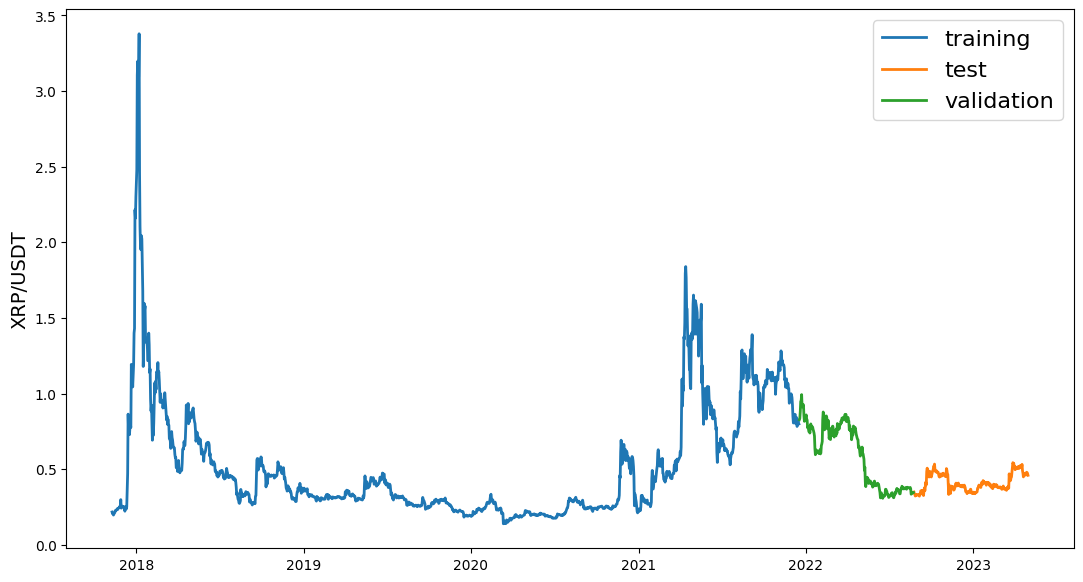

In [ ]:
line_plot(train_data[aim], test_data[aim], val_data[aim], 'training', 'test', 'validation', title='')

Now we need to prepare the data for the LSTM model.

In [ ]:
train_data, test_data, X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    data2, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)
print(X_train.shape)

(1495, 5, 1)


Notice that the shape has changed indicating that we only have one metric now, 'Close'.

Once again we will build and train our model.

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
47/47 [==============================] - 7s 23ms/step - loss: 0.0258 - val_loss: 0.0053
Epoch 2/20
47/47 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0040
Epoch 3/20
47/47 [==============================] - 0s 9ms/step - loss: 0.0146 - val_loss: 0.0037
Epoch 4/20
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0030
Epoch 5/20
47/47 [==============================] - 0s 9ms/step - loss: 0.0128 - val_loss: 0.0028
Epoch 6/20
47/47 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.0028
Epoch 7/20
47/47 [==============================] - 0s 10ms/step - loss: 0.0104 - val_loss: 0.0026
Epoch 8/20
47/47 [==============================] - 0s 10ms/step - loss: 0.0102 - val_loss: 0.0027
Epoch 9/20
47/47 [==============================] - 0s 9ms/step - loss: 0.0094 - val_loss: 0.0024
Epoch 10/20
47/47 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0021
Epoch 11/20
47/

Now let's check the performance.

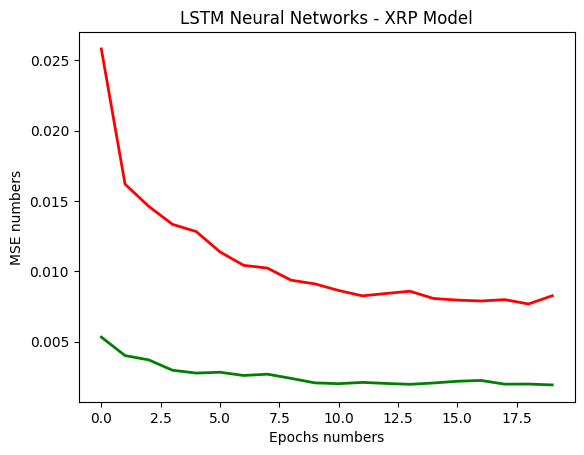

In [ ]:
import matplotlib.pyplot as plt
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [ ]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

8/8 [==============================] - 1s 4ms/step


0.02816213881466133

In [ ]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.0017814725438986964

In [ ]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

73.77446678249488

As we can see the results our very similar to the results in section 1.

Let's take a look at how the predictions look compared to the real prices.

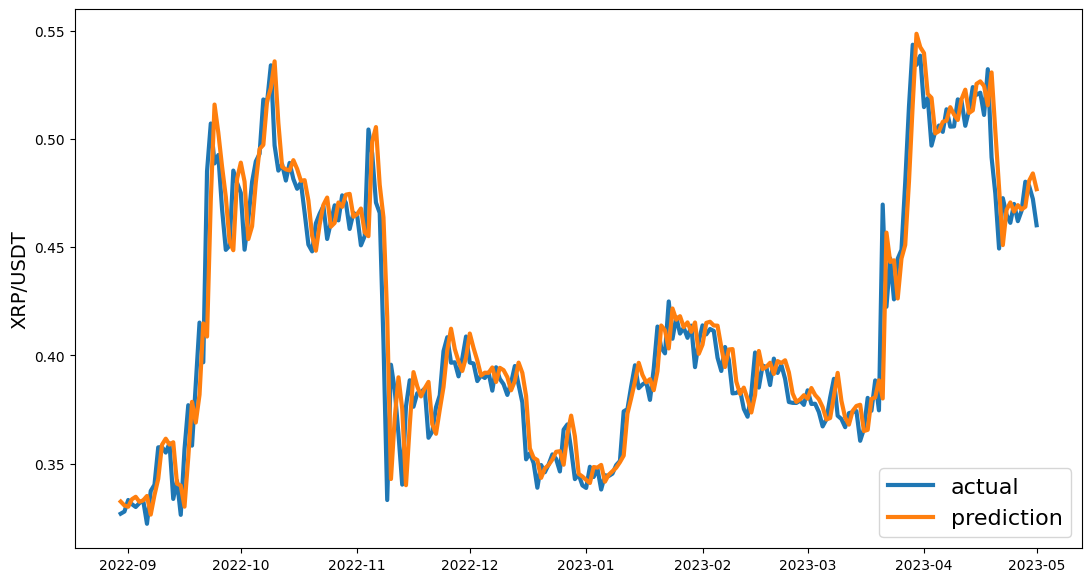

In [ ]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot2(targets, preds, 'actual', 'prediction', lw=3)

As expected the fit looks very good but it suffers from the same flaws we mentioned before and cannot actually predict future prices without already knowing the previous day.

To combat this bias we will create a prediction that uses it's previous predicted closing prices to predict the next day. This will predict one day at a time.

In [ ]:
targets = test_data[aim][window_len:]
prediction = test_data.copy()
prediction_X = X_test.copy()

preds = model.predict(X_test[0:10]).squeeze()


for i in range(0, len(test_data)-15):
  temp = model.predict(prediction_X[i:i+11]).squeeze()
  prediction['Close'][i] = (temp[10]+1)*test_data[aim][i]
  prediction_X = extract_window_data(prediction, window_len, zero_base)

  preds = np.append(preds, temp[10])


1/1 [==============================] - 0s 33ms/step


Now that we have prediction each day independent of the testing data let's see how it performs.

In [ ]:
mean_absolute_error(preds, y_test)

0.028162138737684667

In [ ]:
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.0017814725528022231

In [ ]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

73.7744666514237

In [ ]:
preds = prediction[aim].values[:-window_len] * (preds + 1)

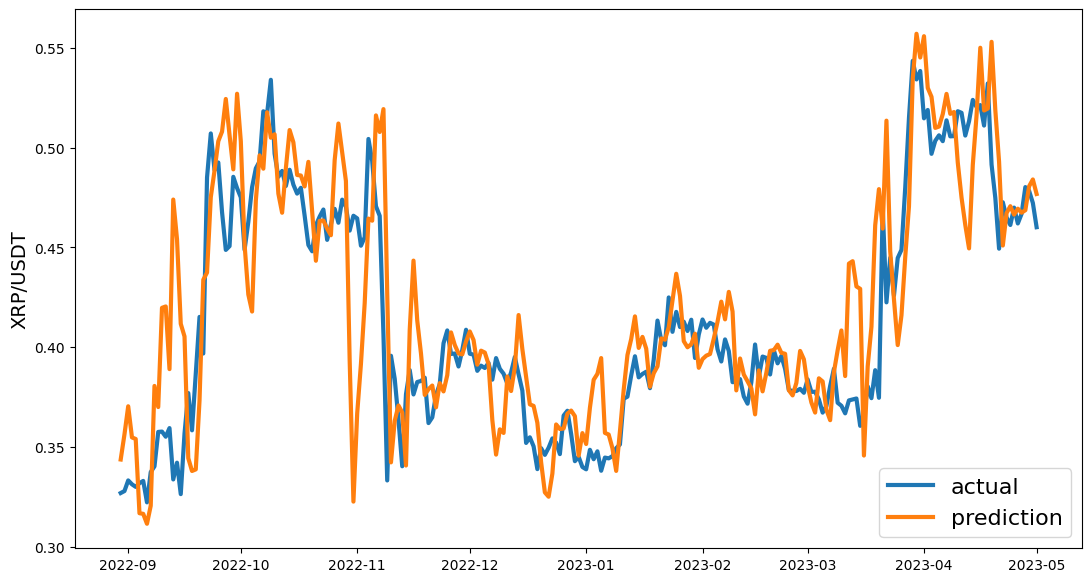

In [ ]:
preds = pd.Series(index=targets.index, data=preds)
line_plot2(targets, preds, 'actual', 'prediction', lw=3)

These results are much more realistic for a model that predicts the future price of XRP. Now we could make predictions for well into the future for days we've never seen based on the previous predictions. 

Let's once again make a day trading simulation based on our predictions.

In [ ]:
# initialize investment parameters
cash = 1000
shares = 0

# simulate investment using preds and target
for i in range(len(preds)):
    if preds[i] > 0:  # buy
        shares_to_buy = int(cash / targets[i])
        if shares_to_buy > 0:  # check if we have enough cash to buy at least one share
            shares += shares_to_buy
            cash -= shares_to_buy * targets[i]
    else:  # sell
        cash += shares * targets[i]
        shares = 0

# print final investment results
print(f"Final cash: ${cash:.2f}")
print(f"Final shares: {shares}")
print(f"Total value: ${cash + shares * targets[-1]:.2f}")

Final cash: $0.11
Final shares: 3059
Total value: $1407.72
